In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Recurrent neural network

- used with sequential data (time series, sentences...)

- parameters: input weights $\mathbf{W}_i$, hidden weights $\mathbf{W}_h$ and output weights $\mathbf{W}_o$

# Forward pass

$$\mathbf{z}_t = \mathbf{h}_{t-1} \cdot \mathbf{W}_h + \mathbf{x}_t \cdot \mathbf{W}_i + \mathbf{b}_i$$
$$\mathbf{h}_{t} = \phi(\mathbf{z}_t)$$

# Gradients

$$\frac{\partial \mathbf{z}_t}{\partial \mathbf{h}_{t-1}} = \mathbf{W}_h \quad \quad \frac{\partial \mathbf{z}_t}{\partial \mathbf{W}_h} = \mathbf{h}_{t-1} \quad \quad \frac{\partial \mathbf{z}_t}{\partial \mathbf{x}} = \mathbf{W}_i \quad \quad \frac{\partial \mathbf{z}_t}{\partial \mathbf{W}_i} = \mathbf{x} \quad \quad \frac{\partial \mathbf{z}_t}{\partial \mathbf{b}_i} = 1$$

$$\frac{\partial \mathbf{h}_t}{\partial \mathbf{z}_t} = \phi'(\mathbf{z}_t)$$

# Backward pass


$$ 

\begin{align*}

\begin{aligned}

\frac{\partial \mathcal{L}_t}{\partial \mathbf{W}_h} &= \left( \frac{\partial \mathcal{L}_t}{\partial \mathbf{h}_t} + \mathbf{g}_{t+1} \cdot \frac{\partial \mathbf{z}_{t+1}}{\partial \mathbf{h}_{t}} \right) \cdot \frac{\partial \mathbf{h}_t}{\partial \mathbf{z}_t} \cdot \frac{\partial \mathbf{z}_t}{\partial \mathbf{W}_h} \\

&= \left( \delta_t + \mathbf{g}_{t+1} \cdot \mathbf{W}_h \right) \cdot \phi'(\mathbf{z}_t)\cdot \mathbf{h}_{t-1} \\

&= \left[\mathbf{d}_t \odot \phi'(\mathbf{z}_t) \right] \cdot \mathbf{h}_{t-1} \\

&= \mathbf{g}_t \cdot \mathbf{h}_{t-1}

\end{aligned} \quad \quad

\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_h} = \sum_t \frac{\partial \mathcal{L}_t}{\partial \mathbf{W}_h}
\end{aligned}

\end{align*}
$$

$$ 

\begin{align*}

\begin{aligned}

\frac{\partial \mathcal{L}_t}{\partial \mathbf{W}_i} &= \left( \frac{\partial \mathcal{L}_t}{\partial \mathbf{h}_t} + \mathbf{g}_{t+1} \cdot \frac{\partial \mathbf{z}_{t+1}}{\partial \mathbf{h}_{t}} \right) \cdot \frac{\partial \mathbf{h}_t}{\partial \mathbf{z}_t} \cdot \frac{\partial \mathbf{z}_t}{\partial \mathbf{W}_i} \\

&= \left( \delta_t + \mathbf{g}_{t+1} \cdot \mathbf{W}_h \right) \cdot \phi'(\mathbf{z}_t)\cdot \mathbf{x}_{t} \\

&= \left[\mathbf{d}_t \odot \phi'(\mathbf{z}_t) \right] \cdot \mathbf{x}_{t} \\

&= \mathbf{g}_t \cdot \mathbf{x}_{t}

\end{aligned} \quad \quad

\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_i} = \sum_t \frac{\partial \mathcal{L}_t}{\partial \mathbf{W}_i}
\end{aligned}

\end{align*}
$$

$$ 

\begin{align*}

\begin{aligned}

\frac{\partial \mathcal{L}_t}{\partial \mathbf{b}_i} &= \left( \frac{\partial \mathcal{L}_t}{\partial \mathbf{h}_t} + \mathbf{g}_{t+1} \cdot \frac{\partial \mathbf{z}_{t+1}}{\partial \mathbf{h}_{t}} \right) \cdot \frac{\partial \mathbf{h}_t}{\partial \mathbf{z}_t} \cdot \frac{\partial \mathbf{z}_t}{\partial \mathbf{b}_i} \\

&= \left( \delta_t + \mathbf{g}_{t+1} \cdot \mathbf{W}_h \right) \cdot \phi'(\mathbf{z}_t)\cdot 1 \\

&= \mathbf{d}_t \odot \phi'(\mathbf{z}_t) \\

&= \mathbf{g}_t

\end{aligned} \quad \quad

\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \mathbf{b}_i} = \sum_t \frac{\partial \mathcal{L}_t}{\partial \mathbf{b}_i}
\end{aligned}

\end{align*}
$$

In [43]:
from dlfs.base import Layer

class RecurrentLayer(Layer):

    def __init__(self, n_inputs: int, n_hidden: int, predict_sequence: bool = False) -> None:
        """
        Recurrent layer.

        Parameters
        ----------
        n_inputs : int
            Number of input features.

        n_hidden : int
            Number of hidden features.

        predict_sequence : bool, default=False
            Whether a sequence or a single element is predicted.

        Attributes
        ----------
        input_weights : numpy.ndarray
            Matrix of input weight coefficients.

        hidden_weights : numpy.ndarray
            Matrix of hidden weight coefficients.

        input_bias : numpy.ndaray
            Vector of input bias coefficients.
        """
        self.predict_sequence = predict_sequence

        k = 1 / np.sqrt(n_hidden)
        self.n_hidden = n_hidden
        self.input_weights = np.random.uniform(-k, k, (n_inputs, n_hidden))
        self.hidden_weights = np.random.uniform(-k, k, (n_hidden, n_hidden))
        self.input_bias = np.random.uniform(-k, k, (n_hidden))
      
    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass using the recurrent layer. Creates hidden states and output attributes.

        Parameters
        ----------
        inputs : numpy.ndarray
            Input matrix.

        Returns
        -------
        None
        """
        # Store inputs for backpropagation
        self.inputs = inputs

        # Store number of samples
        self.n_samples = inputs.shape[0]

        # Store sequence length
        self.sequence_length = inputs.shape[1]

        # Initialize output
        if self.predict_sequence:
            self.output = np.zeros((self.n_samples, self.sequence_length, self.n_hidden))
        else:
            self.output = np.zeros((self.n_samples, self.n_hidden))

        # Initialize hidden states
        self.hidden_states = np.zeros((self.n_samples, self.sequence_length, self.n_hidden))

        # Loop through sequences
        for i, sequence in enumerate(inputs):

            # Loop through elements of sequence
            for j, x in enumerate(sequence):

                # Predict current hidden state
                hidden_t = self._forward_step(x, i, j)

                # Store hidden state for the current sequence and sequence element
                self.hidden_states[i, j] = hidden_t.copy()

            if self.predict_sequence:
                # Hidden states of the current sequence are the predicted sequence
                self.output[i] = self.hidden_states[i].copy()
            else:
                # Last hidden state of the current sequence is the predicted element
                self.output[i] = self.hidden_states[i, -1].copy()

    def backward(self, delta: np.ndarray) -> None:
        """
        Backward pass using the recurrent layer. 
        Creates gradient attributes with respect to input weights, hidden weights, input bias, and inputs.

        Parameters
        ----------
        delta : np.ndarray
            Accumulated gradient obtained by backpropagation.

        Returns
        -------
        None
        """
        # Initialize gradient attributes
        self.dinput_weights = np.zeros_like(self.input_weights)
        self.dhidden_weights = np.zeros_like(self.hidden_weights)
        self.dinput_bias = np.zeros_like(self.input_bias)
        self.dinputs = np.zeros_like(self.inputs, dtype=np.float64)

        # Loop through sequences
        for i in range(self.n_samples - 1, -1, -1):

            # Initialize next hidden gradient for the current sequence
            next_hidden_gradient = None

            # Loop through elements of the sequence in reversed order
            for j in range(self.sequence_length - 1, -1, -1):

                if len(delta.shape) == 2:
                    loss_gradient = delta[i].reshape(1, -1)
                    next_hidden_gradient = self._backward_step(loss_gradient, next_hidden_gradient, i, j)

                elif len(delta.shape) == 3:
                    loss_gradient = delta[i, j].reshape(1, -1)
                    next_hidden_gradient = self._backward_step(loss_gradient, next_hidden_gradient, i, j)

    def _forward_step(self, x: np.ndarray, sequence_idx: int, element_idx: int) -> np.ndarray:
        """
        Helper method used in forward pass of a single element. Computes hidden state.

        Parameters
        ----------
        x : np.ndarray
            Input element.

        sequence_idx : int
            Index of the sequence from input tensor.

        element_idx : int
            Index of the element from sequence.

        Returns
        -------
        hidden_state : np.ndarray
        """

        i, j = sequence_idx, element_idx

        # Reshape to match dimensions
        x = x.reshape(1, -1)

        input_x = np.dot(x, self.input_weights)

        hidden_state = input_x + np.dot(self.hidden_states[i, max(j-1, 0)], self.hidden_weights) + self.input_bias

        # Activation function
        hidden_state = np.tanh(hidden_state)

        return hidden_state
    
    def _backward_step(self, delta: np.ndarray, next_hidden_gradient: np.ndarray, sequence_idx: int, element_idx: int):
        """
        Helper method used in backward pass of a single element. Computes next hidden gradient.

        Parameters
        ----------
        delta : np.ndarray
            Accumulated gradient obtained by backpropagation.

        next_hidden_gradient : np.ndarray
            Gradient used to compute current hidden gradient.

        sequence_idx : int
            Index of the sequence from input tensor.

        element_idx : int
            Index of the element from sequence.

        Returns
        -------
        next_hidden_gradient : np.ndarray
        """

        i, j = sequence_idx, element_idx

        hidden_gradient = delta.copy()
        if next_hidden_gradient is not None:
            hidden_gradient += np.dot(next_hidden_gradient, self.hidden_weights)

        dtanh = 1 - self.hidden_states[i, j]**2
        hidden_gradient *= dtanh

        next_hidden_gradient = hidden_gradient.copy()

        if j > 0:
            self.dhidden_weights += np.dot(self.hidden_states[i, j-1].reshape(-1, 1), hidden_gradient)

        self.dinput_weights += np.dot(self.inputs[i, j].reshape(-1, 1), hidden_gradient)
        self.dinput_bias += hidden_gradient.reshape(-1)
        
        self.dinputs[i, j] += np.dot(self.input_weights, hidden_gradient.T).reshape(-1)

        return next_hidden_gradient

class RNN:

    def __init__(self, n_inputs: int, n_hidden: int, n_layers: int = 1, predict_sequence: bool = False) -> None:
        """
        Recurrent neural network.

        Parameters
        ----------
        n_inputs : int
            Number of input features.

        n_hidden : int
            Number of hidden features.
        """
        if n_layers == 1:
            self.recurrent_layers = [RecurrentLayer(n_inputs, n_hidden, predict_sequence)]
        else:
            self.recurrent_layers = [RecurrentLayer(n_inputs, n_hidden)]
            if predict_sequence:
                for i in range(n_layers - 1):
                    if i == n_layers - 2:
                        self.recurrent_layers.append(RecurrentLayer(n_hidden, n_hidden, predict_sequence=True))
                    else:
                        self.recurrent_layers.append(RecurrentLayer(n_hidden, n_hidden))
            else:
                for i in range(n_layers - 1):
                    self.recurrent_layers.append(RecurrentLayer(n_hidden, n_hidden))

    def forward(self, inputs: np.ndarray) -> None:

        self.recurrent_layers[0].forward(inputs)

        for idx, layer in enumerate(self.recurrent_layers[1:], start=1):
            layer.forward(self.recurrent_layers[idx - 1].hidden_states)

        self.output = self.recurrent_layers[-1].output.copy()

    def backward(self, delta: np.ndarray) -> None:

        self.recurrent_layers[-1].backward(delta)

        for idx, layer in reversed(list(enumerate(self.recurrent_layers[:-1]))):
            layer.backward(self.recurrent_layers[idx + 1].dinputs)

    def __init__(self, n_inputs: int, n_hidden: int, n_layers: int = 1) -> None:
        """
        Recurrent neural network.

        Parameters
        ----------
        n_inputs : int
            Number of input features.

        n_hidden : int
            Number of hidden features.
        """
        self.recurrent_layers = [RecurrentLayerHidden(n_inputs, n_hidden)]
        if n_layers > 1:
            for _ in range(n_layers - 1):
                self.recurrent_layers.append(RecurrentLayerHidden(n_hidden, n_hidden))

    def forward(self, inputs: np.ndarray) -> None:

        self.recurrent_layers[0].forward(inputs)

        for idx, layer in enumerate(self.recurrent_layers[1:], start=1):
            layer.forward(self.recurrent_layers[idx - 1].hidden_states)

        self.output = self.recurrent_layers[-1].output.copy()

    def backward(self, delta: np.ndarray) -> None:

        self.recurrent_layers[-1].backward(delta)

        for idx, layer in reversed(list(enumerate(self.recurrent_layers[:-1]))):
            layer.backward(self.recurrent_layers[idx + 1].dinputs)

In [44]:
def convert_data_to_sequence(X, y, sequence_length, predict_sequence=False):
    X_new = []
    y_new = []

    if predict_sequence:
        for i in range(len(X) - sequence_length):
            X_new.append(X[i:i+sequence_length, :])
            y_new.append(y[i:i+sequence_length])
    else:
        for i in range(len(X) - sequence_length):
            X_new.append(X[i:i+sequence_length, :])
            y_new.append(y[i+sequence_length])

    X_new, y_new = np.array(X_new), np.array(y_new)

    return X_new, y_new

In [45]:
import pandas as pd

data = pd.read_csv('clean_weather.csv', names=['date', 'tmax', 'tmin', 'rain', 'tmax_tomorrow'], header=0)
data.head(10)

,date,tmax,tmin,rain,tmax_tomorrow
0,1970-01-01,60.0,35.0,0.00,52.0
1,1970-01-02,52.0,39.0,0.00,52.0
2,1970-01-03,52.0,35.0,0.00,53.0
3,1970-01-04,53.0,36.0,0.00,52.0
4,1970-01-05,52.0,35.0,0.00,50.0
5,1970-01-06,50.0,38.0,0.00,52.0
6,1970-01-07,52.0,43.0,0.00,56.0
7,1970-01-08,56.0,49.0,0.24,54.0
8,1970-01-09,54.0,50.0,0.40,57.0
9,1970-01-10,57.0,50.0,0.00,57.0


In [46]:
FEATURES = ['tmax', 'tmin', 'rain']
TARGET = 'tmax_tomorrow'

X = data[FEATURES].to_numpy()
y = data[TARGET].to_numpy()

print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (13509, 3)
y: (13509,)


In [47]:
from sklearn.preprocessing import StandardScaler

threshold = 0.3

X_train = X[:int(threshold*len(X)),:].copy()
y_train = y[:int(threshold*len(X))].copy()

X_test = X[int(threshold*len(X)):,:].copy()
y_test = y[int(threshold*len(X)):].copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (4052, 3), y_train: (4052,)
X_test: (9457, 3), y_test: (9457,)


# One to one RNN

In [48]:
seq_len = 1

X_train_one, y_train_one = convert_data_to_sequence(X_train, y_train.reshape(-1, 1), seq_len)
X_test_one, y_test_one = convert_data_to_sequence(X_test, y_test.reshape(-1, 1), seq_len)

print(f'X_train_one: {X_train_one.shape}, y_train_one: {y_train_one.shape}')
print(f'X_test_one: {X_test_one.shape}, y_test_one: {y_test_one.shape}')

X_train_one: (4051, 1, 3), y_train_one: (4051, 1)
X_test_one: (9456, 1, 3), y_test_one: (9456, 1)


In [49]:
print(X_train_one[1])
print(y_train_one[1])

[[-1.5398828  -1.87049442 -0.2670622 ]]
[53.]


In [51]:
from dlfs import Model
from dlfs.loss import MSE_Loss
from dlfs.optimizers import Optimizer_SGD
from dlfs.layers import RecurrentLayer, DenseLayer

np.random.seed(0)

layers = [RecurrentLayer(3, 4),
          DenseLayer(4, 1)]
lr = 1e-4

model = Model(layers=layers, loss_function=MSE_Loss(), optimizer=Optimizer_SGD(learning_rate=lr))
model.train(X_train_one, y_train_one, epochs=50, batch_size=1, print_every=10)

===== EPOCH : 0 ===== LOSS : 73.60776004428513 =====
===== EPOCH : 10 ===== LOSS : 15.776029278875658 =====
===== EPOCH : 20 ===== LOSS : 15.569918778861593 =====
===== EPOCH : 30 ===== LOSS : 15.526936706949586 =====
===== EPOCH : 40 ===== LOSS : 15.5052388477171 =====
===== EPOCH : 50 ===== LOSS : 15.482486155398592 =====


In [61]:
from random import randint

idx = randint(0, len(X_test_one))
sample = X_test_one[idx].reshape(1, *X_test_one[0].shape)
y_pred = model.predict(sample)
print(y_pred)
print(y_test_one[idx])
print(f'Sample loss: {model.loss_function.calculate(y_pred.reshape(-1), y_test_one[idx])}')

[[61.61187444]]
[55.]
Sample loss: 21.858441811735897


In [62]:
from dlfs.layers import RNN

np.random.seed(0)

layers = [RNN(3, 4),
          DenseLayer(4, 1)]
lr = 1e-4

model = Model(layers=layers, loss_function=MSE_Loss(), optimizer=Optimizer_SGD(learning_rate=lr))
model.train(X_train_one, y_train_one, epochs=50, batch_size=1, print_every=10)

===== EPOCH : 0 ===== LOSS : 73.60776004428513 =====
===== EPOCH : 10 ===== LOSS : 15.776029278875658 =====
===== EPOCH : 20 ===== LOSS : 15.569918778861593 =====
===== EPOCH : 30 ===== LOSS : 15.526936706949586 =====
===== EPOCH : 40 ===== LOSS : 15.5052388477171 =====
===== EPOCH : 50 ===== LOSS : 15.482486155398592 =====


In [66]:
idx = randint(0, len(X_test_one))
sample = X_test_one[idx].reshape(1, *X_test_one[0].shape)
y_pred = model.predict(sample)
print(y_pred)
print(y_test_one[idx])
print(f'Sample loss: {model.loss_function.calculate(y_pred.reshape(-1), y_test_one[idx])}')

[[66.88313313]]
[64.]
Sample loss: 4.156228333844812


Sequence loss: 12.850707889434029


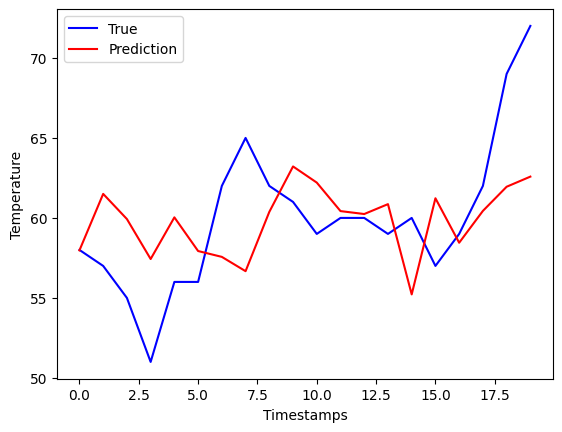

In [72]:
n_samples = 20
x = np.array([x for x in range(n_samples)])

rand_idx = randint(0, len(X_test_one) - n_samples)
y_true = y_test_one[rand_idx:rand_idx+n_samples]

x_pred = X_test_one[rand_idx:rand_idx+n_samples]
y_pred = model.predict(x_pred)
print(f'Sequence loss: {model.loss_function.calculate(y_pred.reshape(-1), y_true)}')

plt.plot(x, y_true, color='blue', label="True")
plt.plot(x, y_pred, color="red", label="Prediction")
plt.xlabel('Timestamps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Many to one RNN

In [73]:
seq_len = 30

X_train_seq, y_train_seq = convert_data_to_sequence(X_train, y_train.reshape(-1, 1), seq_len)
X_test_seq, y_test_seq = convert_data_to_sequence(X_test, y_test.reshape(-1, 1), seq_len)

print(f'X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}')
print(f'X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}')

X_train_seq: (4022, 30, 3), y_train_seq: (4022, 1)
X_test_seq: (9427, 30, 3), y_test_seq: (9427, 1)


In [74]:
np.random.seed(0)

layers = [RecurrentLayer(3, 4), 
          DenseLayer(4, 1),
          ]

lr = 1e-4

model = Model(layers=layers, loss_function=MSE_Loss(), optimizer=Optimizer_SGD(learning_rate=lr))
model.train(X_train_seq, y_train_seq, epochs=50, batch_size=1, print_every=10)

===== EPOCH : 0 ===== LOSS : 65.80175825825364 =====
===== EPOCH : 10 ===== LOSS : 20.117198464698394 =====
===== EPOCH : 20 ===== LOSS : 19.012041619674918 =====
===== EPOCH : 30 ===== LOSS : 19.43938386146679 =====
===== EPOCH : 40 ===== LOSS : 23.87274567452844 =====
===== EPOCH : 50 ===== LOSS : 19.916853817943444 =====


In [85]:
from random import randint

idx = randint(0, len(X_test_seq))
sample = X_test_seq[idx].reshape(1, *X_test_seq[0].shape)
y_pred = model.predict(sample)
print(y_pred)
print(y_test_seq[idx])
print(f'Sample loss: {model.loss_function.calculate(y_pred.reshape(-1), y_test_seq[idx])}')

[[69.69396631]]
[66.]
Sample loss: 6.822693537756656


Sequence loss: 9.270941264096553


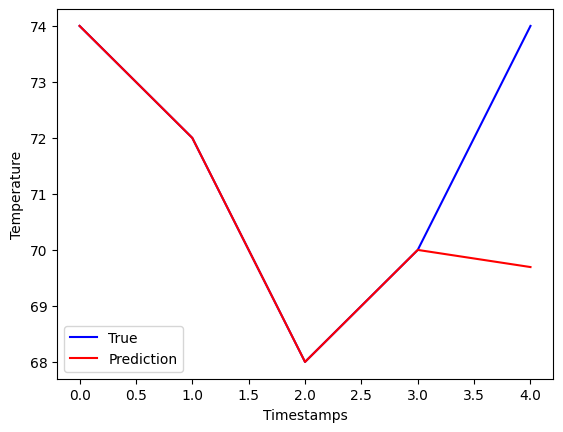

In [98]:
timestamps = 5
x = np.array([x for x in range(timestamps)])

rand_idx = randint(0, len(X_test_seq) - timestamps)
y_true_one = y_test_seq[rand_idx]

x_pred = X_test_seq[rand_idx].reshape(1, *X_test_seq[0].shape)
y_pred_one = model.predict(x_pred).reshape(-1)

print(f'Sequence loss: {model.loss_function.calculate(y_pred_one, y_true_one)}')

y_true = y_test_seq[rand_idx:rand_idx+timestamps]
y_pred = list(y_true.copy())
y_pred.pop()
y_pred.append(y_pred_one)
y_pred = np.array(y_pred)

plt.plot(x, y_true, color='blue', label="True")
plt.plot(x, y_pred, color="red", label="Prediction")
plt.xlabel('Timestamps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Many to many RNN

In [ ]:
seq_len = 30

X_train_seq, y_train_seq = convert_data_to_sequence(X_train, y_train.reshape(-1, 1), seq_len, predict_sequence=True)
X_test_seq, y_test_seq = convert_data_to_sequence(X_test, y_test.reshape(-1, 1), seq_len, predict_sequence=True)

print(f'X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}')
print(f'X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}')

In [ ]:
np.random.seed(0)

layers = [RecurrentLayer(3, 4, predict_sequence=True), 
          DenseLayer(4, 1)]

lr = 1e-3

model = Model(layers=layers, loss_function=MSE_Loss(), optimizer=Optimizer_SGD(learning_rate=lr))
model.train(X_train_seq, y_train_seq, epochs=50, batch_size=32, print_every=10)

In [ ]:
idx = randint(0, len(X_test_seq))
sample = X_test_seq[idx].reshape(1, *X_test_seq[0].shape)
y_pred = model.predict(sample)
print(y_pred.reshape(-1))
print(y_test_seq[idx].reshape(-1))
print(f'Sequence loss: {model.loss_function.calculate(y_pred.reshape(-1), y_test_seq[idx].reshape(-1))}')

In [ ]:
timestamps = 15
x = np.array([x for x in range(timestamps)])

rand_idx = randint(0, len(X_test_seq))
y_true = y_test_seq[rand_idx]

x_pred = X_test_seq[rand_idx].reshape(1, *X_test_seq[0].shape)
y_pred = model.predict(x_pred).flatten()
print(f'Sequence loss: {model.loss_function.calculate(y_pred.reshape(-1), y_true.reshape(-1))}')

plt.plot(x, y_true, color='blue', label="True")
plt.plot(x, y_pred, color="red", label="Prediction")
plt.xlabel('Timestamps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Torch example

In [ ]:
import torch
import torch.nn as nn

# Define the RNN model
class RNNManyToOne(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNManyToOne, self).__init__()
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the output layer (fully connected layer)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state for the first input
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size)#.#to(x.device)
        
        # Pass input through RNN
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Take the output from the last time step (Many-to-One)
        out = out[:, :, :]  # Get the output of the last time step
        
        # Pass it through the fully connected layer
        out = self.fc(out)  # Output shape: (batch_size, output_size)
        
        return out

# Parameters
input_size = 1  # Number of input features (e.g., word embedding size)
hidden_size = 50  # Number of hidden units in RNN
output_size = 1  # Single output (e.g., for binary classification)
num_layers = 1  # Number of RNN layers
sequence_length = 2  # Length of the input sequence
batch_size = 32  # Batch size

# Create the model
model = RNNManyToOne(input_size, hidden_size, output_size, num_layers)

# Loss and optimizer
criterion = nn.MSELoss()  # Binary cross-entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Sample input: (batch_size, sequence_length, input_size)
print(f'x: {sequence_new.shape}')
print(f'y: {result_new.shape}')
inputs = torch.tensor(sequence_new, dtype=torch.float32)

# Sample output: (batch_size, output_size)
labels = torch.tensor(result_new, dtype=torch.float32)  # Binary labels (e.g., 0 or 1 for sentiment)

# Forward pass
for i in range(501):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Loss: {loss.item()}')

In [ ]:
inputs = torch.tensor(sequence_new, dtype=torch.float32)
start = randint(0, len(sequence_new))
length = 1
print(model(inputs[start:start+length]))
print(result_new[start:start+length])